### Ник на kaggle
Игорь_Шумский_455250365

### Импорт бибиотек

In [28]:
import torch
import numpy as np
import zipfile
import os
import PIL
import torch
import pickle
import numpy as np
import warnings
from skimage import io
import pandas as pd
import pretrainedmodels
import torch.optim as optim

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Извлекаем данные

In [4]:
zip_path = 'C:/Users/Игорь/Desktop/dl/dl_scl/14/journey-springfield.zip'
extract_to = 'C:/Users/Игорь/Desktop/dl/dl_scl/14'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
extracted_folder_path = 'C:/Users/Игорь/Desktop/dl/dl_scl/14/'
file_list = os.listdir(extracted_folder_path)

### Проверка что обучение на gpu

In [6]:
torch.cuda.is_available()

True

### Игнорирование предупреждений

In [7]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [8]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

### Создадим класс для нашего датасета
Также добавим аугментацию данных, используя transform1.

In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        transform1 = transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomRotation(25),
            transforms.RandomHorizontalFlip(),
            ])
        
        x = self.load_sample(self.files[index])
        if self.mode != 'test': 
            x = transform1(x)
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        
        if self.mode == 'test':
            x = transform(x)
            return x
        else:
            x = transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [12]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [13]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [14]:
val_dataset = SimpsonsDataset(val_files, mode='val')

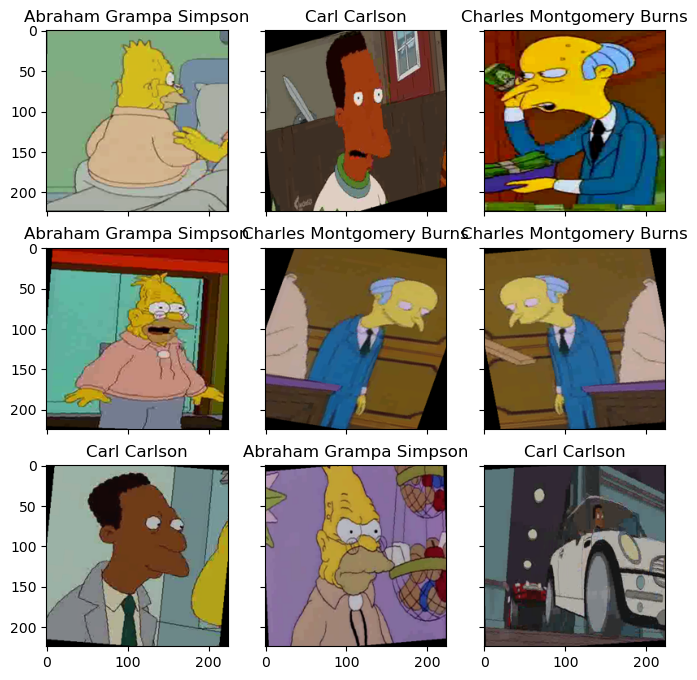

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети
Добавим к изначальной нейросети 2 линейных слоя, батч нормы. Пулинги в изначальной нейросети были.

In [17]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )

        self.fc1 = nn.Sequential(nn.Linear(96 * 5 * 5, 120 * 5),
                                nn.ReLU(),
                                nn.BatchNorm1d(120 * 5)
        )
        self.fc2 = nn.Sequential(nn.Linear(120 * 5, 400),
                              nn.ReLU(),
                              nn.BatchNorm1d(400)

        )
        self.fc3 = nn.Linear(400, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = (self.fc1(x))
        x = (self.fc2(x))
        logits = self.fc3(x)
        return logits

### Функции для обучения моделей

In [18]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [19]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

### Заменим Adam на AdamW и добавим lr_scheduler

In [2]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 2, gamma=0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [21]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Количество классов, которые нужно присваивать, и структура нейросети

In [22]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, paddi

### Датасеты для обучения

In [26]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

### Обучаем модель
Изменим количество эпох и batch_size по сравнению с изначальной моделью

In [31]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=128)

epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

loss 2.8046614588563687


epoch:  10%|███████▌                                                                   | 1/10 [03:09<28:29, 189.99s/it]


Epoch 001 train_loss: 2.8047     val_loss 2.2277 train_acc 0.3244 val_acc 0.4582
loss 1.7961896591121524


epoch:  20%|███████████████                                                            | 2/10 [06:29<26:03, 195.43s/it]


Epoch 002 train_loss: 1.7962     val_loss 1.6380 train_acc 0.5295 val_acc 0.5608
loss 1.4059786911686254


epoch:  30%|██████████████████████▌                                                    | 3/10 [09:42<22:41, 194.50s/it]


Epoch 003 train_loss: 1.4060     val_loss 1.3886 train_acc 0.6183 val_acc 0.6173
loss 1.1723518646768007


epoch:  40%|██████████████████████████████                                             | 4/10 [12:53<19:17, 192.93s/it]


Epoch 004 train_loss: 1.1724     val_loss 1.2690 train_acc 0.6775 val_acc 0.6626
loss 0.9893802431284436


epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [16:00<15:55, 191.05s/it]


Epoch 005 train_loss: 0.9894     val_loss 1.1580 train_acc 0.7207 val_acc 0.6870
loss 0.8725460821013897


epoch:  60%|█████████████████████████████████████████████                              | 6/10 [19:07<12:37, 189.41s/it]


Epoch 006 train_loss: 0.8725     val_loss 1.0786 train_acc 0.7521 val_acc 0.7081
loss 0.7723010834086981


epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [22:13<09:25, 188.58s/it]


Epoch 007 train_loss: 0.7723     val_loss 1.0471 train_acc 0.7821 val_acc 0.7266
loss 0.6854334614544023


epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [25:20<06:16, 188.07s/it]


Epoch 008 train_loss: 0.6854     val_loss 0.9888 train_acc 0.8036 val_acc 0.7371
loss 0.6088223898438893


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [28:37<03:10, 190.71s/it]


Epoch 009 train_loss: 0.6088     val_loss 0.9441 train_acc 0.8248 val_acc 0.7484
loss 0.5427295860951703


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [31:54<00:00, 191.45s/it]


Epoch 010 train_loss: 0.5427     val_loss 0.9311 train_acc 0.8430 val_acc 0.7581


### Построим кривые обучения

In [32]:
loss, acc, val_loss, val_acc = zip(*history)

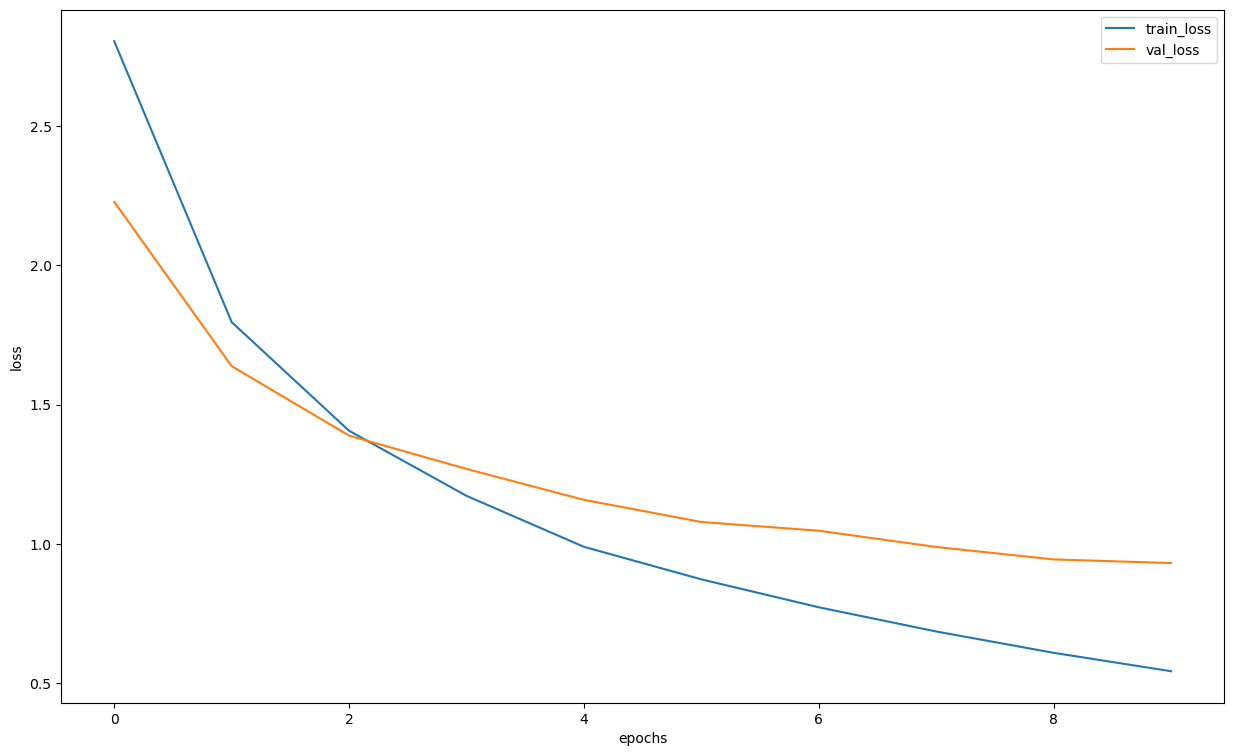

In [33]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Предсказания модели

In [34]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [35]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [36]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [37]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [38]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

### F1-оценка

In [39]:
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.85


### Предсказания модели с картинками

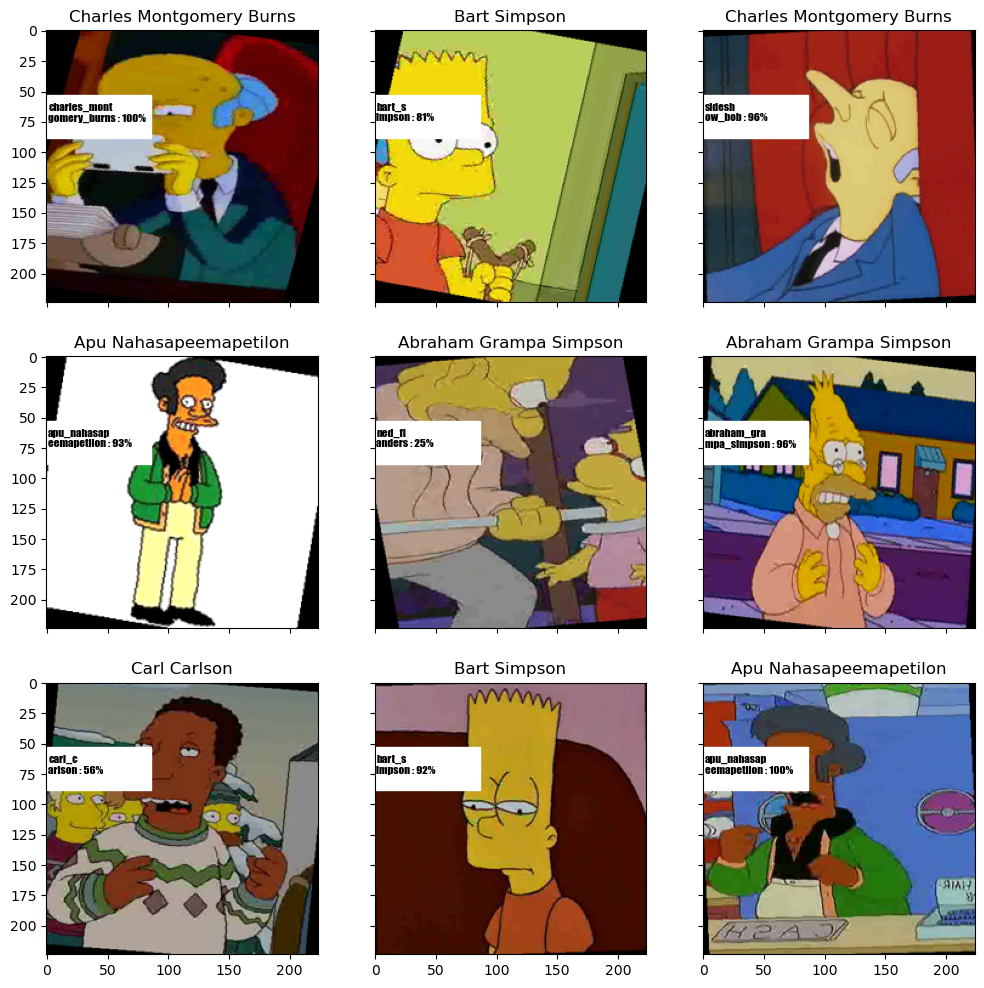

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Постараемся улучшить результат, используя предобученные модели
Заморозим у resnet50 все слои кроме последнего и заменим последний линейный слой на тот, который будет предсказывать ответы для данной задачи

In [59]:
model_name = 'resnet50'
model1 = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')   
for param in model1.parameters():
    param.requires_grad = False
for param in model1.layer4.parameters():
    param.requires_grad = True

num_features = 2048
model1.last_linear = nn.Linear(num_features, 42)
model1 = model1.to(DEVICE)

C:\conda\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\conda\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Датасеты для обучения

In [60]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
loaders = {
    "train": train_loader,
    "valid": val_loader
}

### Обучение модели
Увеличим ещё раз количество эпох

In [61]:
history = train(train_dataset, val_dataset, model=model1, epochs=15, batch_size=128)

epoch:   0%|                                                                                    | 0/15 [00:00<?, ?it/s]

loss 1.197983490161375


epoch:   7%|████▊                                                                    | 1/15 [04:39<1:05:06, 279.05s/it]


Epoch 001 train_loss: 1.1980     val_loss 0.5109 train_acc 0.7404 val_acc 0.8896
loss 0.3814194805417534


epoch:  13%|█████████▋                                                               | 2/15 [09:27<1:01:43, 284.86s/it]


Epoch 002 train_loss: 0.3814     val_loss 0.4220 train_acc 0.9029 val_acc 0.8942
loss 0.2266710461471193


epoch:  20%|███████████████                                                            | 3/15 [13:36<53:41, 268.45s/it]


Epoch 003 train_loss: 0.2267     val_loss 0.2695 train_acc 0.9416 val_acc 0.9329
loss 0.17255094831833012


epoch:  27%|████████████████████                                                       | 4/15 [17:43<47:38, 259.91s/it]


Epoch 004 train_loss: 0.1726     val_loss 0.2646 train_acc 0.9518 val_acc 0.9375
loss 0.13691255740697494


epoch:  33%|█████████████████████████                                                  | 5/15 [22:22<44:27, 266.70s/it]


Epoch 005 train_loss: 0.1369     val_loss 0.2385 train_acc 0.9622 val_acc 0.9425
loss 0.1121727088462134


epoch:  40%|██████████████████████████████                                             | 6/15 [26:45<39:47, 265.30s/it]


Epoch 006 train_loss: 0.1122     val_loss 0.2477 train_acc 0.9673 val_acc 0.9467
loss 0.09144818680769654


epoch:  47%|███████████████████████████████████                                        | 7/15 [31:01<35:00, 262.53s/it]


Epoch 007 train_loss: 0.0914     val_loss 0.2297 train_acc 0.9738 val_acc 0.9459
loss 0.08289861827054155


epoch:  53%|████████████████████████████████████████                                   | 8/15 [35:31<30:52, 264.66s/it]


Epoch 008 train_loss: 0.0829     val_loss 0.2386 train_acc 0.9759 val_acc 0.9421
loss 0.07273957607313147


epoch:  60%|█████████████████████████████████████████████                              | 9/15 [40:01<26:38, 266.40s/it]


Epoch 009 train_loss: 0.0727     val_loss 0.2233 train_acc 0.9803 val_acc 0.9515
loss 0.05086787581466092


epoch:  67%|█████████████████████████████████████████████████▎                        | 10/15 [44:12<21:48, 261.73s/it]


Epoch 010 train_loss: 0.0509     val_loss 0.2117 train_acc 0.9861 val_acc 0.9541
loss 0.05700031212294388


epoch:  73%|██████████████████████████████████████████████████████▎                   | 11/15 [48:30<17:22, 260.55s/it]


Epoch 011 train_loss: 0.0570     val_loss 0.2710 train_acc 0.9847 val_acc 0.9471
loss 0.05076030176399874


epoch:  80%|███████████████████████████████████████████████████████████▏              | 12/15 [52:43<12:54, 258.32s/it]


Epoch 012 train_loss: 0.0508     val_loss 0.2422 train_acc 0.9850 val_acc 0.9446
loss 0.04098683638726346


epoch:  87%|████████████████████████████████████████████████████████████████▏         | 13/15 [57:00<08:35, 257.92s/it]


Epoch 013 train_loss: 0.0410     val_loss 0.2289 train_acc 0.9882 val_acc 0.9484
loss 0.03988151172491249


epoch:  93%|███████████████████████████████████████████████████████████████████▏    | 14/15 [1:01:15<04:17, 257.07s/it]


Epoch 014 train_loss: 0.0399     val_loss 0.2335 train_acc 0.9880 val_acc 0.9513
loss 0.041344993489060185


epoch: 100%|████████████████████████████████████████████████████████████████████████| 15/15 [1:05:39<00:00, 262.61s/it]


Epoch 015 train_loss: 0.0413     val_loss 0.2503 train_acc 0.9885 val_acc 0.9455


### Построим кривые обучения

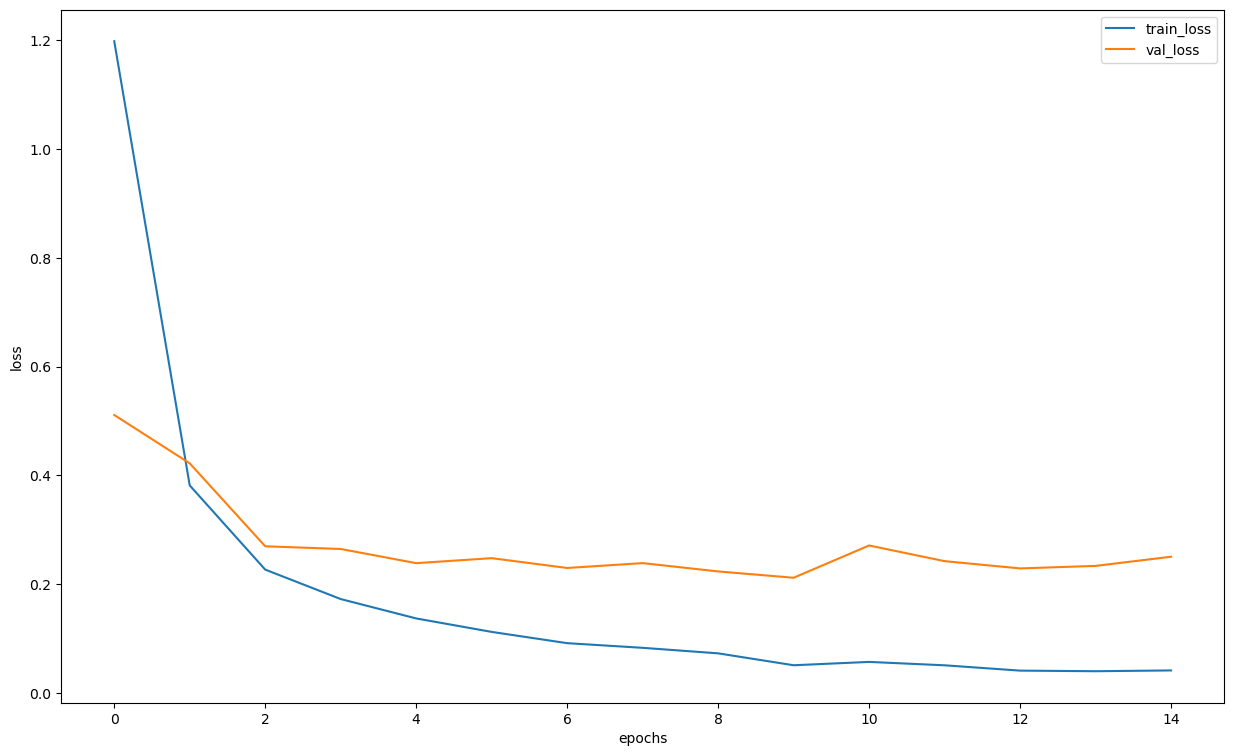

In [62]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Предсказания модели

In [63]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [64]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model1, ex_img.unsqueeze(0))

In [65]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model1, imgs)

In [66]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [67]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

### F1-оценка

In [68]:
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.9500000000000001


### Submit на Kaggle

In [69]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(model1, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [70]:
#my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [71]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)